In [1]:
# Imports
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [120]:
# Stolen from odd erik
def graph3d(X, y, f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')

    x_scatt, z_scatt = [i.tolist()[0] for i in X.T]
    y_scatt = y.T.tolist()[0]
    ax.scatter3D(x_scatt, z_scatt, y_scatt,  c='r')

    x_min = min(x_scatt)
    x_max = max(x_scatt)
    dx = x_max - x_min
    z_min = min(z_scatt)
    z_max = max(z_scatt)
    dz = z_max - z_min

    x_lin = np.linspace(x_min - 0.1*dx, x_max + 0.1*dx, num=30)
    z_lin = np.linspace(z_min - 0.1*dz, z_max + 0.1*dz, num=30)
    x_mesh, z_mesh = np.meshgrid(x_lin, z_lin)
    y_mesh = f(x_mesh, z_mesh)  # often works withut mesh unravelling, but in c mesh unravelling was needed, and many tears were shed
    ax.plot_surface(x_mesh, z_mesh, y_mesh, alpha=0.8)
    plt.show()

def f_grid(x_mesh, z_mesh, W1, W2, b1, b2):
    y_mesh = np.empty(np.shape(x_mesh))

    for i in range(0, x_mesh.shape[0]):
        for j in range(0, x_mesh.shape[1]):
            v = f_real([[x_mesh[i, j], z_mesh[i, j]]], W1, W2, b1, b2)
            y_mesh[i, j] = v

    return y_mesh

f_temp = lambda x, z: f_grid(x, z, W1, W2, b1, b2)

In [76]:
# Loading testdata
data = pd.read_csv('testdata_xor.csv')

x = np.mat(data.iloc[:, 0:2].values)
y = np.mat(data.iloc[:, 2:].values)
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.25, random_state=0)

In [104]:
class ClassificationModel():
    def __init__(self):
        self.x = tf.placeholder(tf.float32)
        self.y = tf.placeholder(tf.float32)
        
        self.W1 = tf.Variable([[10.0, -10.0], [10.0, -10.0]])
        self.b1 = tf.Variable([[-5.0, 15.0]])
        
        self.W2 = tf.Variable([[10.0], [10.0]])
        self.b2 = tf.Variable([[-15.0]])
        
        logits1 = tf.matmul(self.x, self.W1) + self.b1
        self.h = tf.sigmoid(logits1)
        
        logits2 = tf.matmul(self.h, self.W2) + self.b2
        self.f = tf.sigmoid(logits2)
        
        self.loss = tf.losses.sigmoid_cross_entropy(self.y, logits2)

In [105]:
# Creating and training model
model = ClassificationModel()
mini_op = tf.train.GradientDescentOptimizer(0.001).minimize(model.loss)

session = tf.Session()
session.run(tf.global_variables_initializer())

for i in range(10000):
    session.run(mini_op, {model.x: x_train, model.y: y_train})
    
# Geting Ws, bs and loss from model
W1, W2, b1, b2, loss = session.run([model.W1, model.W2, model.b1, model.b2, model.loss], {model.x: x_test, model.y: y_test})

In [110]:
# Predicting results from testdata and printing accuracy
temp_preds = session.run([model.f], {model.x: x_test, model.y: y_test})

# Compares observations and predictions (add .5 to observation to get int 0 or 1)
predictions = [int(i) for i in temp_preds[0]+0.5]
ys = y_test

number_correct = sum([int(predictions[x] == ys[x]) for x in range(len(ys))])

print(str(number_correct/len(ys)*100) + '% correct')

100.0% correct


In [113]:
# Print variables
print(W1)
print(W2)
print(b1)
print(b2)
print(loss)

[[ 10. -10.]
 [ 10. -10.]]
[[10.0190735]
 [10.0190735]]
[[-5. 15.]]
[[-15.]]
0.007353144


<IPython.core.display.Javascript object>


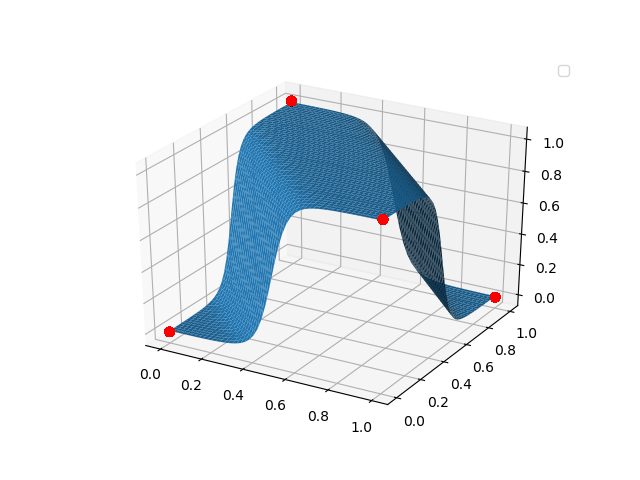

W0827 17:40:34.188330 139841208473408 legend.py:1282] No handles with labels found to put in legend.


In [134]:
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')

x_plot = np.linspace(0,1)
z_plot = np.linspace(0,1)

X, Z = np.meshgrid(x_plot, z_plot)

# y_real = np.mat(  1/(1 +np.e**-(X * W1[0, 0] + Z * W1[1, 0]  + b1[0, 0]) )    ).transpose()

matrix_hell = ([(X*W1[0,0] + Z*W1[1,0]), (X*W1[0,1] + Z*W1[1,1])])


x_matrix_hell_1 = matrix_hell[0] + b1[0,0]
x_matrix_hell_2 = matrix_hell[1] + b1[0,1]

f1_matrix_1 = 1 / (1 + np.e**-(x_matrix_hell_1))
f1_matrix_2 = 1/ (1 + np.e**-(x_matrix_hell_2))

y_real = 1 / (1 + np.e**-( f1_matrix_1 * W2[0,0] +f1_matrix_2 1* W2[1,0] + b2[0]    ))

ax.plot_surface(X, Z, y_real)

ax.scatter([x for x in x_test[:, 0]], [y for y in x_test[:, 1]], y_test, c='red', s=40.0)

plt.legend()
plt.show()